# 訓練 (ConvVAE)

## モデル

#### Encoder

-  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
-  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
-  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
-  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
-  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
-  (conv6): Conv2d(128, 64, kernel_size=(4, 4), stride=(1, 1))
-  (linear): Linear(in_features=64, out_features=2, bias=True)

#### Decoder
-  (t_linear): Linear(in_features=2, out_features=64, bias=True)
-  (t_conv6): ConvTranspose2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
-  (t_conv5): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))[:, :, :-1, :-1]
-  (t_conv4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))[:, :, :-1, :-1]
-  (t_conv3): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2))[:, :, 1:-2, 1:-2]
-  (t_conv2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(2, 2))[:, :, 1:-2, 1:-2]
-  (t_conv1): ConvTranspose2d(8, 1, kernel_size=(5, 5), stride=(2, 2))[:, :, 1:-2, 1:-2]

### 潜在ベクトル: 64

### 訓練

- 400 epoch回したけど、もっと回しても良さそう

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
from pprint import pprint
import sys
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

In [ ]:
sys.path.append("/home/kwk/share/mizuho/u00257/vae_clustering/src/")

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [24]:
import importlib
import vae_model
importlib.reload(vae_model)

<module 'vae_model' from '/home/kwk/share/mizuho/u00257/vae_clustering/src/vae_model.py'>

In [25]:
from vae_preprocess import dataset2d
from vae_model import ConvVAE
from img_shows import *

In [5]:
batch_size = 100
data_pkls = ".,/data_pkls/"
pkl_files = [data_pkls + "imgs128_1.pkl", data_pkls + "imgs128_2.pkl", data_pkls + "imgs128_3.pkl"]
dataset = dataset2d(pkl_files)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [6]:
print(dataset[0].shape)

torch.Size([1, 128, 128])


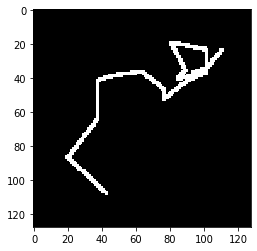

In [7]:
plt.imshow(dataset[0].to("cpu").reshape(dataset[0].shape[1], dataset[0].shape[1]), cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')

In [26]:
model_name = "ConvVAE"
img_size = dataset[0].shape[1]
model = ConvVAE(img_size).to(device)
print(model)

ConvVAE(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(4, 4), stride=(1, 1))
  (conv_mean): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv_var): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
  (t_conv7): ConvTranspose2d(64, 1024, kernel_size=(1, 1), stride=(1, 1))
  (t_conv6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(1, 1))
  (t_conv5): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
  (t_conv4): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
  (t_conv3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
  (t_conv2): ConvTranspose2d(64, 16

In [27]:
def loss_function(reconstructed_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [28]:
# criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

In [29]:
num_save = 400
num_epochs = 1
train_ls = []

### 訓練

モデルの保存はCPUへ

In [30]:
for n in range(num_save):
    if n == 325 :
        optimizer.defaults["lr"] = 0.0005
    if n == 375:
        optimizer.defaults["lr"] = 0.0001
    for epoch in range(num_epochs):
        
        t1 = time.time()
        loss_sum = 0.0
        for i, batch_imgs in enumerate(dataloader):
            optimizer.zero_grad()
            reconstructed_imgs, mu, logvar = model(batch_imgs.to(device))
            loss = loss_function(reconstructed_imgs, batch_imgs.to(device), mu, logvar)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

        t2 = time.time()
        train_ls.append(loss_sum)

        print("epoch --- %d train_loss: %.3f (train time: %.1f s = %.1f min)" %(n * num_epochs + epoch + 1, loss_sum, t2 - t1, (t2 - t1) / 60))
    torch.save(model.state_dict(), "../model_pths/" + model_name + ".pth")

epoch --- 1 train_loss: 61628572.094 (train time: 19.9 s = 0.3 min)
epoch --- 2 train_loss: 47604896.219 (train time: 19.7 s = 0.3 min)
epoch --- 3 train_loss: 44309717.922 (train time: 19.7 s = 0.3 min)
epoch --- 4 train_loss: 42692535.875 (train time: 19.5 s = 0.3 min)
epoch --- 5 train_loss: 41468296.484 (train time: 19.7 s = 0.3 min)
epoch --- 6 train_loss: 40318583.344 (train time: 19.6 s = 0.3 min)
epoch --- 7 train_loss: 39392628.047 (train time: 19.6 s = 0.3 min)
epoch --- 8 train_loss: 38591748.062 (train time: 19.8 s = 0.3 min)
epoch --- 9 train_loss: 37847889.109 (train time: 19.6 s = 0.3 min)
epoch --- 10 train_loss: 37111904.609 (train time: 19.6 s = 0.3 min)
epoch --- 11 train_loss: 36466768.641 (train time: 19.8 s = 0.3 min)
epoch --- 12 train_loss: 35787799.969 (train time: 19.5 s = 0.3 min)
epoch --- 13 train_loss: 35094036.438 (train time: 19.6 s = 0.3 min)
epoch --- 14 train_loss: 34422161.719 (train time: 19.8 s = 0.3 min)
epoch --- 15 train_loss: 33687944.609 (trai

epoch --- 120 train_loss: 16987251.664 (train time: 19.7 s = 0.3 min)
epoch --- 121 train_loss: 16874732.117 (train time: 19.7 s = 0.3 min)
epoch --- 122 train_loss: 16854322.492 (train time: 19.5 s = 0.3 min)
epoch --- 123 train_loss: 16860686.570 (train time: 19.6 s = 0.3 min)
epoch --- 124 train_loss: 16807972.875 (train time: 19.7 s = 0.3 min)
epoch --- 125 train_loss: 16747031.531 (train time: 22.1 s = 0.4 min)
epoch --- 126 train_loss: 16753611.523 (train time: 41.8 s = 0.7 min)
epoch --- 127 train_loss: 16720321.578 (train time: 41.6 s = 0.7 min)
epoch --- 128 train_loss: 16678194.000 (train time: 23.2 s = 0.4 min)
epoch --- 129 train_loss: 16668764.625 (train time: 19.5 s = 0.3 min)
epoch --- 130 train_loss: 16628910.703 (train time: 19.8 s = 0.3 min)
epoch --- 131 train_loss: 16617533.391 (train time: 22.7 s = 0.4 min)
epoch --- 132 train_loss: 16581533.359 (train time: 21.7 s = 0.4 min)
epoch --- 133 train_loss: 16509999.242 (train time: 21.4 s = 0.4 min)
epoch --- 134 train_

epoch --- 238 train_loss: 14600019.047 (train time: 19.7 s = 0.3 min)
epoch --- 239 train_loss: 14553901.781 (train time: 19.6 s = 0.3 min)
epoch --- 240 train_loss: 14585835.500 (train time: 19.4 s = 0.3 min)
epoch --- 241 train_loss: 14542288.000 (train time: 19.5 s = 0.3 min)
epoch --- 242 train_loss: 14517371.758 (train time: 19.6 s = 0.3 min)
epoch --- 243 train_loss: 14508045.992 (train time: 19.6 s = 0.3 min)
epoch --- 244 train_loss: 14498953.031 (train time: 19.5 s = 0.3 min)
epoch --- 245 train_loss: 14514229.945 (train time: 19.4 s = 0.3 min)
epoch --- 246 train_loss: 14503973.891 (train time: 19.5 s = 0.3 min)
epoch --- 247 train_loss: 14489332.906 (train time: 19.6 s = 0.3 min)
epoch --- 248 train_loss: 14440870.734 (train time: 19.7 s = 0.3 min)
epoch --- 249 train_loss: 14441189.727 (train time: 19.6 s = 0.3 min)
epoch --- 250 train_loss: 14460221.820 (train time: 19.5 s = 0.3 min)
epoch --- 251 train_loss: 14401343.250 (train time: 19.5 s = 0.3 min)
epoch --- 252 train_

epoch --- 356 train_loss: 13529827.520 (train time: 19.7 s = 0.3 min)
epoch --- 357 train_loss: 13518411.152 (train time: 19.7 s = 0.3 min)
epoch --- 358 train_loss: 13540822.105 (train time: 19.5 s = 0.3 min)
epoch --- 359 train_loss: 13524353.957 (train time: 19.5 s = 0.3 min)
epoch --- 360 train_loss: 13510958.773 (train time: 19.6 s = 0.3 min)
epoch --- 361 train_loss: 13480598.387 (train time: 19.7 s = 0.3 min)
epoch --- 362 train_loss: 13497252.574 (train time: 19.7 s = 0.3 min)
epoch --- 363 train_loss: 13477200.164 (train time: 19.5 s = 0.3 min)
epoch --- 364 train_loss: 13477581.570 (train time: 19.5 s = 0.3 min)
epoch --- 365 train_loss: 13478466.535 (train time: 19.6 s = 0.3 min)
epoch --- 366 train_loss: 13459010.699 (train time: 19.7 s = 0.3 min)
epoch --- 367 train_loss: 13463804.832 (train time: 19.6 s = 0.3 min)
epoch --- 368 train_loss: 13476689.418 (train time: 19.5 s = 0.3 min)
epoch --- 369 train_loss: 13434920.934 (train time: 20.6 s = 0.3 min)
epoch --- 370 train_

In [31]:
def plot_results(result, which_result, condition, save_or_not=True):
    plt.clf()
    plt.plot(result)
    plt.title(condition + "_" + which_result)
    plt.savefig(condition + "_" + which_result + ".png") if save_or_not else plt.show()

In [32]:
loss_img_path = "../loss_imgs/"
condition = "ConvVAE_128to64"

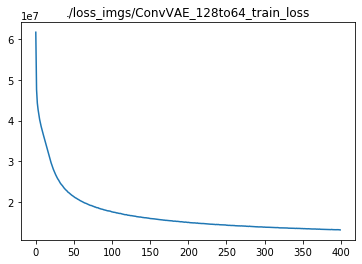

In [33]:
plot_results(train_ls, "train_loss", loss_img_path + condition)

In [34]:
poses = [1000,2000,3000,4000,5000,6000]

<Figure size 432x288 with 0 Axes>

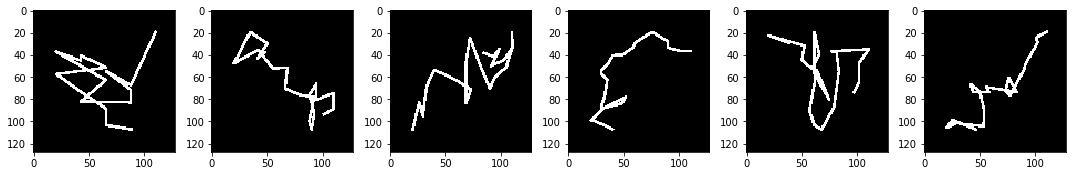

In [37]:
imshow_conv(dataset, poses)

<Figure size 432x288 with 0 Axes>

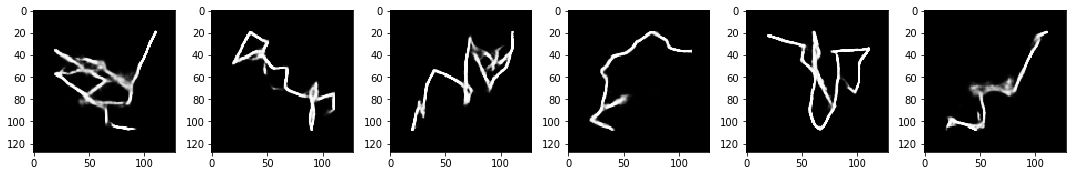

In [44]:
imshow_conv(dataset, poses, model=model, device=device)

In [32]:
import subprocess
subprocess.run(['jupyter', 'nbconvert', '--to', 'python', 'vae_train_ConvVAE.ipynb'])

CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'python', 'vae_train_ConvAE.ipynb'], returncode=0)